In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input

C:\Users\gupta\anaconda3\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


## Pong
Policy gradient with memory buffer - varying probs to oversample minority (cases when you win), action every 4 frame, and linear annealing

In [2]:
# function to convert each image into lesser size
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [4]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(16,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(mid)
    mid = Conv2D(64,(3,3),strides=1,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(512,activation='relu')(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(3,activation='softmax')(mid)
    model = Model(imp,out0) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=25e-6),loss=tf.keras.losses.Huber())
    
    return model

In [5]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,2,3]
mod = create_model(80,80,frames_to_net)
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 16)        4112      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 512)               1180160   
                                                                 
 dense_1 (Dense)             (None, 256)               131328

In [6]:
# linear annealing with same actions for 4 games
def play1game(model, eps):
    env0 = gym.make("Pong-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    feed_reward = 0
    action = np.random.choice(3)
    action0 = possible_actions[action]
    done = False
    while not done:
        # updating action every 4 frames
        # but taking that action for the 4 frames just not using the prediction for action
        if (frames_this_game % 4 == 0) & (frames_this_game != 0):
            frame_array.append(feed)
            action_array.append(action)
            reward_array.append(feed_reward)
            
            vf = model(feed,training=False).numpy()[0]
            # print(vf)
            if np.random.random() < eps:
                action = np.random.choice(3,p=vf)
                action0 = possible_actions[action]
            else:
                action = np.argmax(vf)
                action0 = possible_actions[action]           
            
            feed_reward = 0
        
        pix_new, reward, done, info = env0.step(action0)
        feed_reward += reward 
        
        pix = prepro(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
        
    return frame_array, action_array, reward_array, score

In [7]:
def get_action(pixels):
    paddle1_start = 10
    paddle2_start = 70
    
    ball_area = pixels[:, paddle1_start:paddle2_start]
    ball_row = np.mean(np.where(ball_area > 0)[0])
    
    paddle_area = pixels[:, paddle2_start:paddle2_start+2]
    paddle_row = np.mean(np.where(paddle_area > 0)[0])
    
    if ball_row > paddle_row:
        return 2
    elif ball_row < paddle_row:
        return 1 
    else:
        return 0
    

# heuristically playing the games
def playhgame():

    env = gym.make("Pong-v0")
    pixels = env.reset()
    pixels = prepro(pixels)
    
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pixels.copy()
    
    frame_array = []
    action_array = []
    reward_array = []
    frames_this_game = 0

    action = get_action(feed[0, :, :, 0]) # we'll eventually pick the action from a NN
    action0 = possible_actions[action]
    
    score = 0
    feed_reward = 0
    done = False # done gets returned from the environment to tell you if this game (first to 21 points) is over

    while not done:
        if (frames_this_game % 4 == 0):
            frame_array.append(feed)
            action_array.append(action)
            reward_array.append(feed_reward)
            
            action = get_action(feed[0, :, :, 0]) # we'll eventually pick the action from a NN
            action0 = possible_actions[action]
            
            feed_reward = 0

        raw_pixels, reward, done, info = env.step(action0)
        feed_reward += reward
        
        pixels = prepro(raw_pixels) # now this is the new frame
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pixels.copy()
        score += reward
        
    return frame_array, action_array, reward_array, score
        

In [8]:
# testing the likelihood of taking each action without any training
frames, actions, rewards, score = play1game(mod,0.5)
print(np.mean(np.array(actions)==0),np.mean(np.array(actions)==1),np.mean(np.array(actions)==2))
print('rewards', sum(rewards), '\n')

frames, actions, rewards, score = playhgame()
print('rewards', sum(rewards), '\n')

C:\Users\gupta\anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Pong-v5`.
  logger.warn(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


0.23333333333333334 0.15757575757575756 0.6090909090909091
rewards -20.0 



C:\Users\gupta\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gupta\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


rewards -17.0 



In [9]:
# discounting factor
delt = 0.99

# setting up variable for memory buffer
ngames = 5000
# ngames = 100
nbatch = 10
buffn = 200000
warmupgames = 100
# warmupgames = 10
len_buff = 0
buffer = {'frames':[],'actions':[], 'rewards':[]}

# eps vector for each gradient for linear annealing
epsvec = np.linspace(1,0.05,ngames)
output_qdl = {'game':[-1]*ngames, 'score':[-100]*ngames, 'time':[-1]*ngames}


In [10]:

overall_start = time.time()

for game in range(ngames):
    start = time.time()
    
    if game < warmupgames:
        # play the game with heuristics
        eps = epsvec[0]
        frames, actions, rewards, score = playhgame()      
    else:
        eps = epsvec[game - warmupgames]
        frames, actions, rewards, score = play1game(mod, eps)
    
    rewards = discount_rewards(rewards.copy())
        
    buffer['frames'] += frames.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)
    if len_buff > buffn:
        excess = len_buff - buffn
        buffer['frames'] = buffer['frames'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['rewards'])
    rewards = np.array(rewards)
    actions = np.array(actions)
    nframes = len(frames)
    current_frames = np.zeros((nframes,80,80,frames_to_net))

    if game >= warmupgames:
        # choosing the frames from memory buffer based on the reward
        # weighing the frames 
        # something like over/under sampling in unbalanced class
        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 5.0
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
    
        for grab in range(nframes):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            
            current_frames[grab,:,:,:] = buffer['frames'][which_choose[grab]].copy()
    
        mod.fit(current_frames,actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
    stop = time.time()
    # print(game, score, stop-start,len_buff)

    output_qdl['game'][game] = game
    output_qdl['score'][game] = score
    output_qdl['time'][game] = time
    
    if game % 10 == 0:
        print('Game number ', game, [score, eps, stop-start], len_buff)

overall_end = time.time()
print('total run time, ', (overall_end - overall_start)/60, 'minutes')

Game number  0 [-17.0, 1.0, 1.7186803817749023] 689
Game number  10 [-20.0, 1.0, 1.4450321197509766] 6899
Game number  20 [-18.0, 1.0, 1.4970734119415283] 13150
Game number  30 [-11.0, 1.0, 2.774538040161133] 19484
Game number  40 [-19.0, 1.0, 1.5698120594024658] 25718
Game number  50 [-17.0, 1.0, 1.9969744682312012] 31867
Game number  60 [-21.0, 1.0, 1.8057525157928467] 37538
Game number  70 [-14.0, 1.0, 2.0492284297943115] 43168
Game number  80 [-13.0, 1.0, 2.2766804695129395] 49315
Game number  90 [-19.0, 1.0, 1.5752968788146973] 55303
Game number  100 [-21.0, 1.0, 2.882202625274658] 60710
Game number  110 [-21.0, 0.9980996199239848, 2.208559036254883] 63774
Game number  120 [-21.0, 0.9961992398479695, 2.0091092586517334] 66836
Game number  130 [-21.0, 0.9942988597719544, 2.1313512325286865] 69664
Game number  140 [-21.0, 0.9923984796959392, 1.7722299098968506] 72216
Game number  150 [-21.0, 0.990498099619924, 1.9878606796264648] 74764
Game number  160 [-21.0, 0.9885977195439087, 2.

Game number  1180 [-21.0, 0.7947589517903582, 2.0931777954101562] 200000
Game number  1190 [-21.0, 0.7928585717143429, 2.1161301136016846] 200000
Game number  1200 [-21.0, 0.7909581916383277, 2.0512709617614746] 200000
Game number  1210 [-21.0, 0.7890578115623125, 2.228537082672119] 200000
Game number  1220 [-21.0, 0.7871574314862972, 2.380222797393799] 200000
Game number  1230 [-21.0, 0.7852570514102821, 2.4493682384490967] 200000
Game number  1240 [-21.0, 0.7833566713342669, 2.4630064964294434] 200000
Game number  1250 [-21.0, 0.7814562912582517, 2.3967432975769043] 200000
Game number  1260 [-21.0, 0.7795559111822364, 2.312598466873169] 200000
Game number  1270 [-21.0, 0.7776555311062212, 2.3209283351898193] 200000
Game number  1280 [-21.0, 0.7757551510302061, 2.2019402980804443] 200000
Game number  1290 [-21.0, 0.7738547709541909, 2.303370714187622] 200000
Game number  1300 [-21.0, 0.7719543908781756, 2.2566304206848145] 200000
Game number  1310 [-21.0, 0.7700540108021605, 2.3118767

Game number  2310 [-21.0, 0.5800160032006402, 1.9529304504394531] 200000
Game number  2320 [-21.0, 0.5781156231246249, 1.81870698928833] 200000
Game number  2330 [-21.0, 0.5762152430486098, 1.888706922531128] 200000
Game number  2340 [-21.0, 0.5743148629725945, 1.8367512226104736] 200000
Game number  2350 [-21.0, 0.5724144828965794, 1.9158964157104492] 200000
Game number  2360 [-21.0, 0.5705141028205641, 1.9054977893829346] 200000
Game number  2370 [-21.0, 0.5686137227445489, 1.9559130668640137] 200000
Game number  2380 [-21.0, 0.5667133426685338, 1.960174798965454] 200000
Game number  2390 [-21.0, 0.5648129625925186, 1.9873363971710205] 200000
Game number  2400 [-21.0, 0.5629125825165033, 1.7803575992584229] 200000
Game number  2410 [-21.0, 0.5610122024404882, 1.9631502628326416] 200000
Game number  2420 [-21.0, 0.5591118223644729, 1.9287407398223877] 200000
Game number  2430 [-21.0, 0.5572114422884578, 1.9229819774627686] 200000
Game number  2440 [-21.0, 0.5553110622124425, 1.9671139

Game number  3440 [-21.0, 0.3652730546109223, 1.7766664028167725] 200000
Game number  3450 [-21.0, 0.36337267453490707, 1.9576632976531982] 200000
Game number  3460 [-21.0, 0.36147229445889184, 2.017458200454712] 200000
Game number  3470 [-21.0, 0.3595719143828766, 1.9598181247711182] 200000
Game number  3480 [-21.0, 0.3576715343068615, 2.0129189491271973] 200000
Game number  3490 [-21.0, 0.35577115423084626, 1.8901972770690918] 200000
Game number  3500 [-21.0, 0.35387077415483104, 1.984262228012085] 200000
Game number  3510 [-21.0, 0.3519703940788158, 1.84507155418396] 200000
Game number  3520 [-21.0, 0.3500700140028006, 2.017130136489868] 200000
Game number  3530 [-21.0, 0.34816963392678546, 1.7663085460662842] 200000
Game number  3540 [-21.0, 0.34626925385077023, 1.9738445281982422] 200000
Game number  3550 [-21.0, 0.344368873774755, 1.8908231258392334] 200000
Game number  3560 [-21.0, 0.3424684936987398, 1.9964959621429443] 200000
Game number  3570 [-21.0, 0.34056811362272466, 2.05

Game number  4560 [-21.0, 0.15243048609721954, 1.9052112102508545] 200000
Game number  4570 [-21.0, 0.1505301060212043, 2.057790517807007] 200000
Game number  4580 [-21.0, 0.14862972594518908, 1.9797742366790771] 200000
Game number  4590 [-21.0, 0.14672934586917397, 1.9684827327728271] 200000
Game number  4600 [-21.0, 0.14482896579315874, 2.0299277305603027] 200000
Game number  4610 [-21.0, 0.1429285857171435, 2.016568660736084] 200000
Game number  4620 [-21.0, 0.14102820564112828, 1.846738576889038] 200000
Game number  4630 [-21.0, 0.13912782556511316, 1.9317986965179443] 200000
Game number  4640 [-21.0, 0.13722744548909793, 2.0592124462127686] 200000
Game number  4650 [-21.0, 0.1353270654130827, 2.009206771850586] 200000
Game number  4660 [-21.0, 0.13342668533706747, 1.9463930130004883] 200000
Game number  4670 [-21.0, 0.13152630526105236, 1.9851040840148926] 200000
Game number  4680 [-21.0, 0.12962592518503713, 1.9789166450500488] 200000
Game number  4690 [-21.0, 0.1277255451090219,

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([4.896e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

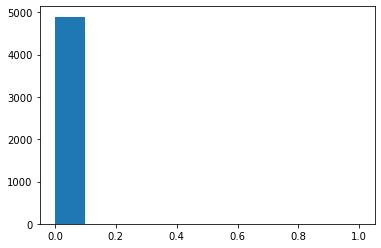

In [12]:
import matplotlib.pyplot as plt
plt.hist([x+21 for x in output_qdl['score'][warmupgames:] if x > -100])

In [ ]:
mod.save('saved_model/pgv3')

(array([174.,   0.,  18.,   0.,   4.,   0.,   3.,   0.,   0.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

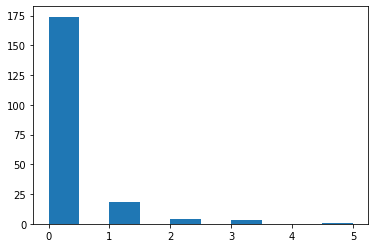

In [65]:
nsims = 200
score_list = []

for sim in range(nsims):
    _, _, _, score = play1game(mod,0.05)
    
    score_list.append(score)

plt.hist([x+21 for x in score_list])  